# This is a work in progress, submitting it to see the weight of the assihgnment

In [70]:
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
"""
Can't load LinearDiscriminantAnalysis
Can't load MultinomialNB

"""
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dtale
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn import metrics
import pickle

%matplotlib
%matplotlib inline
pd.options.display.float_format = '{:.4f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00
pd.set_option('display.max_columns', 100) #  display all the columns
pd.set_option('display.max_rows', 100) # display all the rows
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

Using matplotlib backend: MacOSX


# Loading data

In [3]:
df = pd.read_csv('Data/Binary_label_K_bins_train.csv')
df = df.sample(10000)
df.drop('Unnamed: 0',axis='columns',inplace=True)
X_train = df.drop('training labels',axis='columns')
y_train = df[['training labels']]

In [4]:
df = pd.read_csv('Data/Binary_label_K_bins_test.csv')
df = df.sample(1000)
df.drop('Unnamed: 0',axis='columns',inplace=True)
X_test = df.drop('testing labels',axis='columns')
y_test = df[['testing labels']]


# Logistic Regression

In [5]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

/Users/babyhandzzz/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/babyhandzzz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
train_score = logisticRegr.score(X_train, y_train)
test_score = logisticRegr.score(X_test, y_test)

# These results are derived using the entire dataset
* using only those labels that signify a definitive outcome

In [7]:
print('Preliminary results for Logistic Regression:')
print('train score: ',train_score)
print('test score: ',test_score)

Preliminary results for Logistic Regression:
train score:  0.9799
test score:  0.976


# Saving the model

In [273]:
filename = 'Models/logit_model.sav'
pickle.dump(logisticRegr, open(filename, 'wb')) 

#load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [274]:
logisticRegr.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)>

In [275]:
loaded_model = pickle.load(open(filename, 'rb'))

# Initial modeling

In [ ]:
classifiers = [LogisticRegression(random_state=1234),  
               KNeighborsClassifier(), 
               RandomForestClassifier(random_state=1234)]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

# Plotting ROC

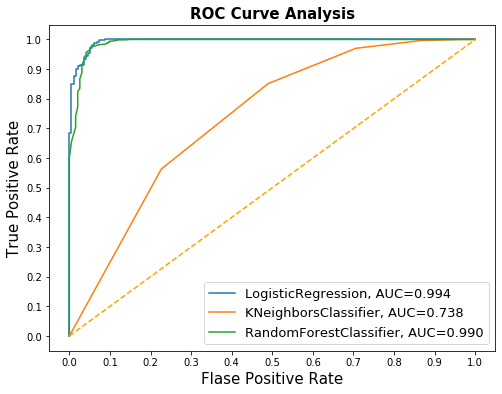

In [49]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# Confusion matrix of the best model

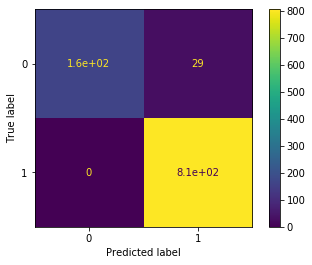

In [57]:
plot_confusion_matrix(model,X_test,y_test)
plt.show()

# Cross-Validation

In [ ]:
logreg = LogisticRegression(class_weight='balanced')
param = {'C':[0.001,0.05,0.1,0.3,0.5,1,4,5,10,20,30]}
clf = GridSearchCV(logreg,param,scoring='roc_auc',refit=True,cv=10)
clf.fit(X_train,y_train)

In [66]:
print('Best roc_auc: {:.4}, with hyperparameter: {}'.format(clf.best_score_, clf.best_params_))


Best roc_auc: 0.9951, with hyperparameter: {'C': 10}
